In [ ]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType, IntegerType, FloatType


In [ ]:


from pyspark.sql import SparkSession

# create SparkSession
spark = SparkSession.builder.appName("ReadFiles").getOrCreate()



# set file path
file_path = "/users/lokesheravelli/Downloads/zillow-prize-1-2/"


# read multiple CSV files into DataFrame
df = spark.read.csv(['train_2016_v2.csv', 'train_2017.csv','properties_2016.csv','properties_2017.csv'], header=True, inferSchema=True)

# display first 5 rows of DataFrame
df.show(50)


23/04/24 10:17:05 WARN Utils: Your hostname, Lokeshs-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.251.55.33 instead (on interface en0)
23/04/24 10:17:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/04/24 10:17:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/04/24 10:17:07 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/04/24 10:17:23 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+---------------------+------------------------+------------+-----------+----------+-------------------+---------------------+-----------------+----------+------------------------+----------------------------+--------------------+--------------------+--------------------+--------------------+-------------------+----+------------+-----------+------------+---------------+--------------+---------------------+--------+----------+-----------------+-------+-----------+------------+-----------+-----------+-------------------------+---------------------+------------------+----------------------+------------+--------------+--------------------+-----------+-------+-----------+-------------------+----------------------+-------+------------------+------------------+---------+---------------+-------------+--------------------------+-----------------+--------------+---------------------+---------+------------------+------------------+-------------------+
|parcelid|airconditioningtypeid|arch

In [ ]:
# set file path
file_path = "/users/lokesheravelli/Downloads/"

# read train datasets
train16 = spark.read.csv(file_path + "train_2016_v2.csv", header=True, inferSchema=True)
train17 = spark.read.csv(file_path + "train_2017.csv", header=True, inferSchema=True)

# read properties datasets
prop16 = spark.read.csv(file_path + "properties_2016.csv", header=True, inferSchema=True)
prop17 = spark.read.csv(file_path + "properties_2017.csv", header=True, inferSchema=True)

# merge train and properties datasets for 2016
df16 = train16.join(prop16, "parcelid")

# merge train and properties datasets for 2017
df17 = train17.join(prop17, "parcelid")

# merge both 2016 and 2017 datasets
df = df16.union(df17)


In [ ]:
df.show(5)


+--------+--------+---------------+---------------------+------------------------+------------+-----------+----------+-------------------+---------------------+-----------------+----------+------------------------+----------------------------+--------------------+--------------------+--------------------+--------------------+-------------------+----+------------+-----------+------------+---------------+--------------+---------------------+--------+----------+-----------------+-------+-----------+------------+-----------+-----------+-------------------------+---------------------+------------------+----------------------+------------+--------------+--------------------+-----------+-------+-----------+-------------------+----------------------+-------+------------------+------------------+---------+---------------+-------------+--------------------------+-----------------+--------------+---------------------+---------+------------------+------------------+-------------------+
|parcelid|l

In [ ]:



# get the shape of the dataset
print("Shape of dataset: ", (df.count(), len(df.columns)))

# get the data types of each column
df.printSchema()


Shape of dataset:  (167888, 60)
root
 |-- parcelid: integer (nullable = true)
 |-- logerror: double (nullable = true)
 |-- transactiondate: date (nullable = true)
 |-- airconditioningtypeid: integer (nullable = true)
 |-- architecturalstyletypeid: integer (nullable = true)
 |-- basementsqft: integer (nullable = true)
 |-- bathroomcnt: double (nullable = true)
 |-- bedroomcnt: double (nullable = true)
 |-- buildingclasstypeid: integer (nullable = true)
 |-- buildingqualitytypeid: integer (nullable = true)
 |-- calculatedbathnbr: double (nullable = true)
 |-- decktypeid: integer (nullable = true)
 |-- finishedfloor1squarefeet: integer (nullable = true)
 |-- calculatedfinishedsquarefeet: double (nullable = true)
 |-- finishedsquarefeet12: integer (nullable = true)
 |-- finishedsquarefeet13: integer (nullable = true)
 |-- finishedsquarefeet15: integer (nullable = true)
 |-- finishedsquarefeet50: integer (nullable = true)
 |-- finishedsquarefeet6: integer (nullable = true)
 |-- fips: intege

In [ ]:
# get the list of (column_name, data_type) tuples
data_types = df.dtypes

# count the number of columns with each distinct data type
data_type_counts = {}
for column_name, data_type in data_types:
    if data_type in data_type_counts:
        data_type_counts[data_type] += 1
    else:
        data_type_counts[data_type] = 1

# print the results
for data_type, count in data_type_counts.items():
    print("Number of columns with data type {0}: {1}".format(data_type, count))


Number of columns with data type int: 40
Number of columns with data type double: 13
Number of columns with data type date: 1
Number of columns with data type boolean: 2
Number of columns with data type string: 3
Number of columns with data type bigint: 1


In [ ]:
# he data types of the columns are already appropriate for most of the columns. However, there are a few potential improvements:

#Latitude and Longitude columns can be converted to double for better precision.
#fips column could be treated as a string, as it represents a categorical variable (Federal Information Processing Standards code).


from pyspark.sql.types import DoubleType, StringType

# Converting latitude and longitude columns to double
df = df.withColumn("latitude", df["latitude"].cast(DoubleType()))
df = df.withColumn("longitude", df["longitude"].cast(DoubleType()))

# Converting fips column to string
df1 = df.withColumn("fips", df["fips"].cast(StringType()))


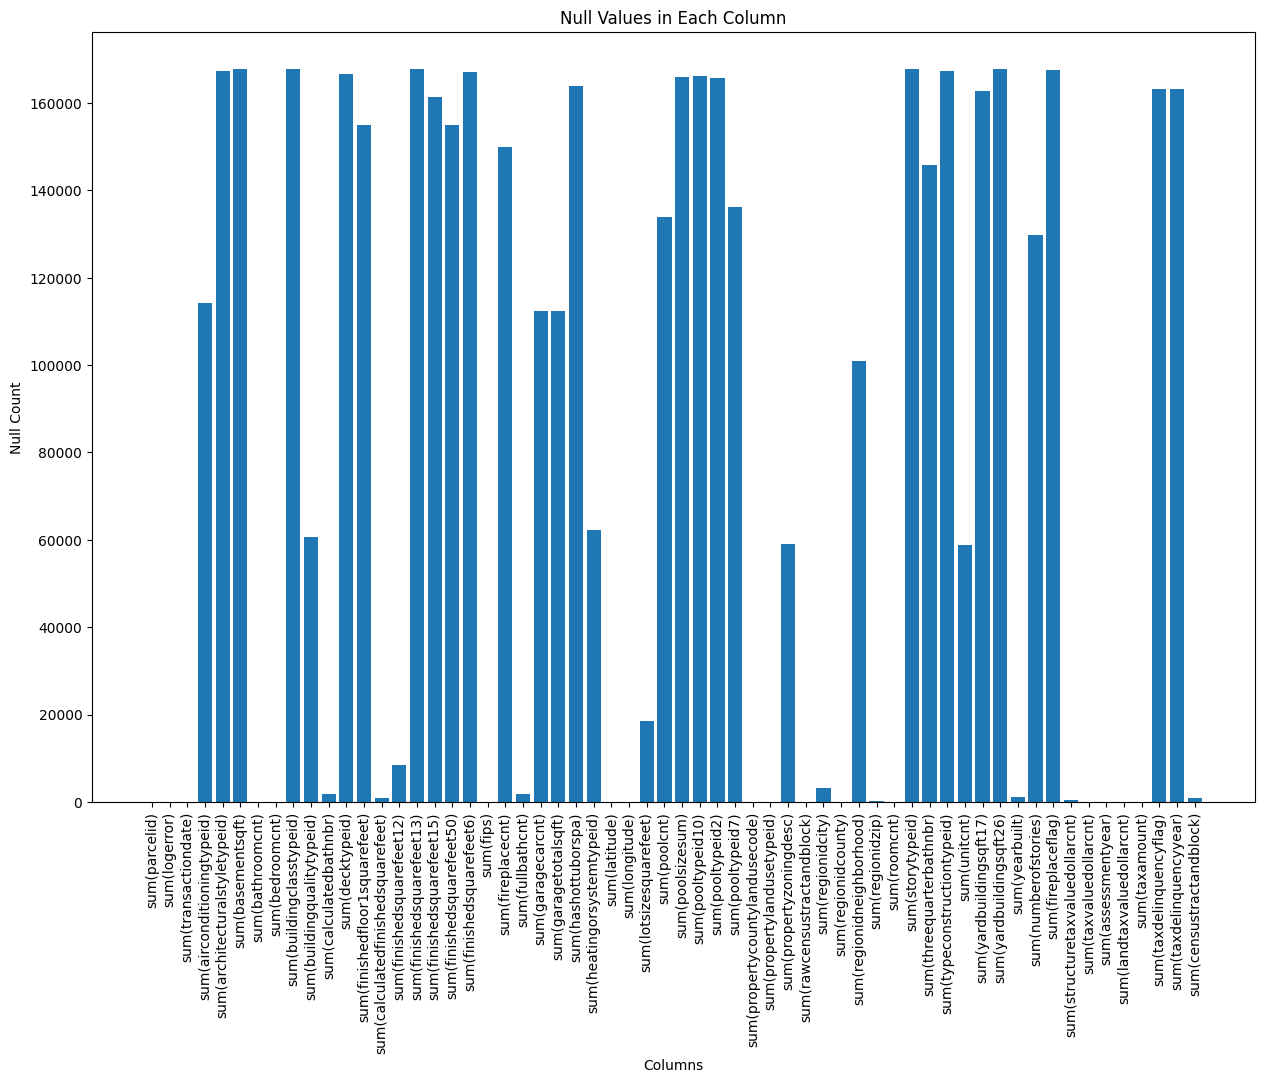

In [ ]:
from pyspark.sql.functions import col, when
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the count of null values per column
null_counts = df1.select([when(col(c).isNull(), 1).otherwise(0).alias(c) for c in df.columns]).groupBy().sum()

# Convert the null counts to a Pandas DataFrame
null_counts_pd = null_counts.toPandas().transpose()
null_counts_pd.reset_index(level=0, inplace=True)
null_counts_pd.columns = ["Column", "Null Count"]

# Plot the null values using a bar plot
plt.figure(figsize=(15, 10))
plt.bar(null_counts_pd["Column"], null_counts_pd["Null Count"])
plt.xticks(rotation=90)
plt.xlabel("Columns")
plt.ylabel("Null Count")
plt.title("Null Values in Each Column")
plt.show()


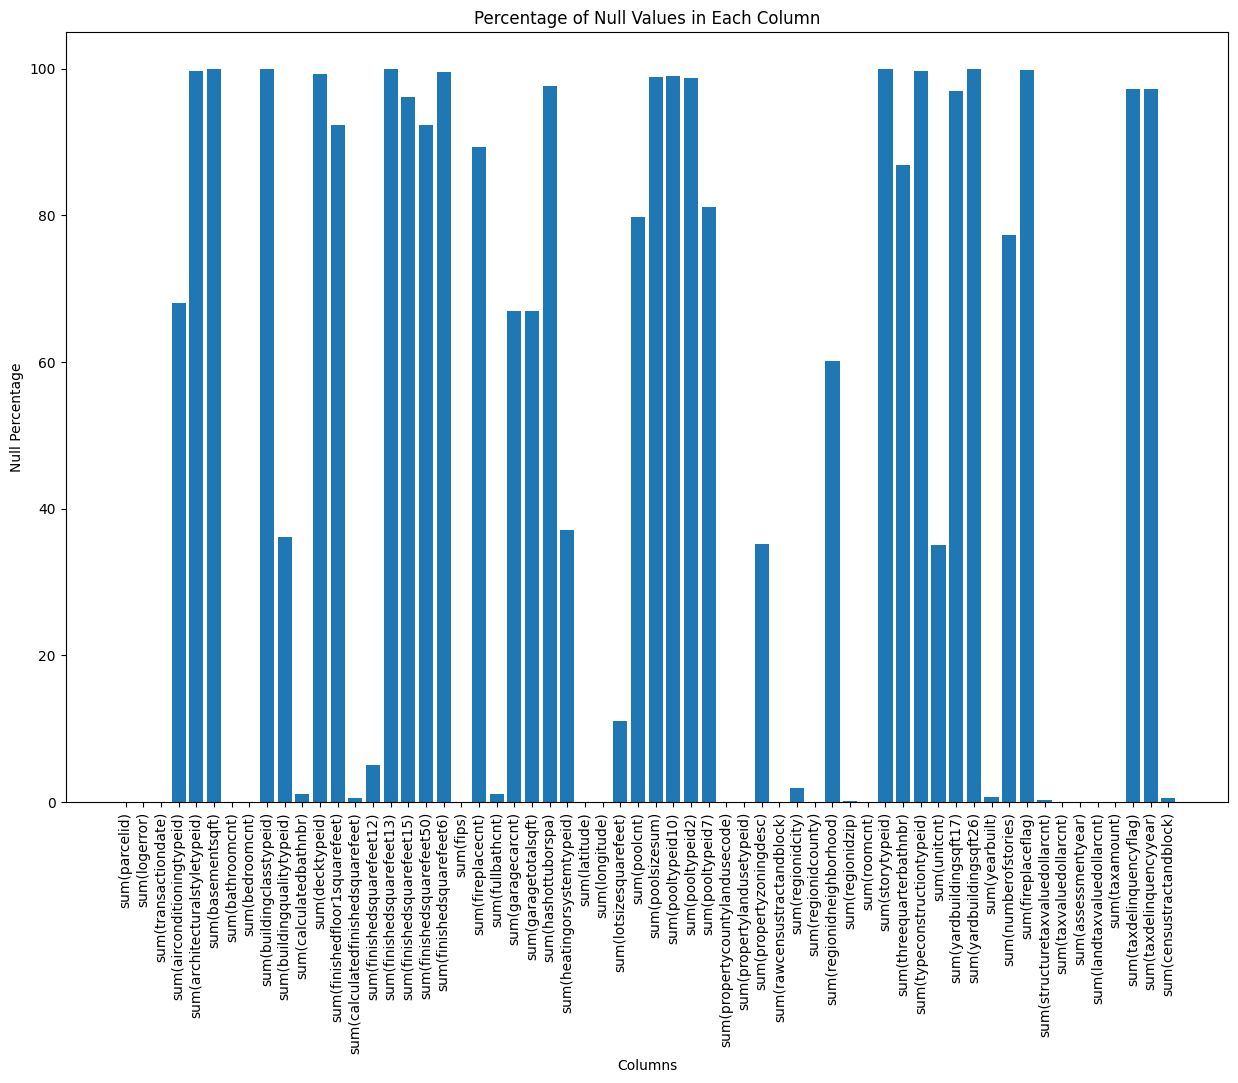

In [ ]:
# Calculate the percentage of null values
total_rows = df1.count()
null_counts_pd["Null Percentage"] = (null_counts_pd["Null Count"] / total_rows) * 100

# Plot the null values percentage using a bar plot
plt.figure(figsize=(15, 10))
plt.bar(null_counts_pd["Column"], null_counts_pd["Null Percentage"])
plt.xticks(rotation=90)
plt.xlabel("Columns")
plt.ylabel("Null Percentage")
plt.title("Percentage of Null Values in Each Column")
plt.show()

#  code will first calculate the null percentage for each column and then drop the columns with more than 90% null values.

In [ ]:
from pyspark.sql.functions import col, count, when

# Calculate null percentage for each column
null_counts = df1.select([(count(when(col(c).isNull(), c)) / df1.count()).alias(c) for c in df1.columns])

# Get the columns with more than 90% null values
null_threshold = 0.9
null_counts_dict = null_counts.collect()[0].asDict()

# List the columns that you do not want to drop
columns_not_to_drop = ['fireplaceflag', 'hashottuborspa', 'taxdelinquencyflag']

# Filter the columns to drop based on the null threshold and exclude the columns_not_to_drop
columns_to_drop = [k for k, v in null_counts_dict.items() if v > null_threshold and k not in columns_not_to_drop]

# Drop the columns
df2 = df1.drop(*columns_to_drop)


Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:535)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)




from pyspark.sql.functions import col, count, when

# Calculate null percentage for each column
null_counts = df1.select([(count(when(col(c).isNull(), c)) / df.count()).alias(c) for c in df.columns])

# Get the columns with more than 90% null values
null_threshold = 0.9
null_counts_dict = null_counts.collect()[0].asDict()
columns_to_drop = [k for k, v in null_counts_dict.items() if v > null_threshold]

# Drop the columns
df2 = df1.drop(*columns_to_drop)


# data shape after droping columns 90% threshold 

In [ ]:

# get the shape of the dataset
print("Shape of dataset: ", (df2.count(), len(df2.columns)))

Shape of dataset:  (167888, 43)


In [ ]:
df2.show(5)

+--------+--------+---------------+---------------------+-----------+----------+---------------------+-----------------+----------------------------+--------------------+----+------------+-----------+------------+---------------+--------------+---------------------+-----------+-------------+-----------------+-------+-----------+-------------------------+---------------------+------------------+----------------------+------------+--------------+--------------------+-----------+-------+-------------------+-------+---------+---------------+-------------+--------------------------+-----------------+--------------+---------------------+---------+------------------+-------------------+
|parcelid|logerror|transactiondate|airconditioningtypeid|bathroomcnt|bedroomcnt|buildingqualitytypeid|calculatedbathnbr|calculatedfinishedsquarefeet|finishedsquarefeet12|fips|fireplacecnt|fullbathcnt|garagecarcnt|garagetotalsqft|hashottuborspa|heatingorsystemtypeid|   latitude|    longitude|lotsizesquarefeet|p

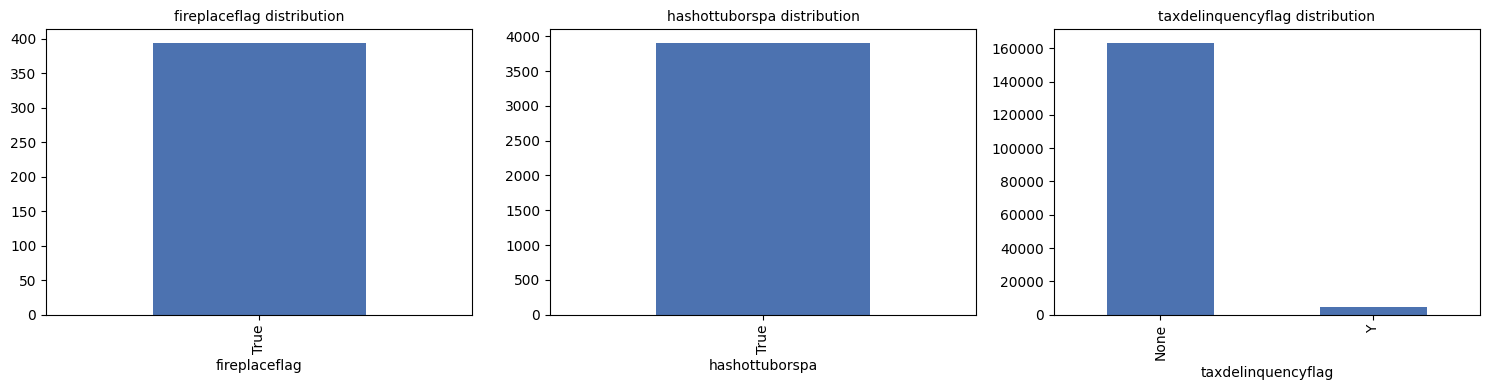

In [ ]:
from pyspark.sql.functions import col, when
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt

# Assuming 'df2' is your PySpark DataFrame
columns_to_plot = ['fireplaceflag', 'hashottuborspa', 'taxdelinquencyflag']

# Replace null values in those columns with 'None'
df2 = df2.fillna('None', subset=columns_to_plot)

# Plot the value distribution for each column
num_cols = len(columns_to_plot)
fig, axes = plt.subplots(nrows=1, ncols=num_cols, figsize=(5 * num_cols, 4))

for i, col_name in enumerate(columns_to_plot):
    # Convert the PySpark column to Pandas Series for plotting
    pandas_series = df2.select(col_name).toPandas()[col_name]
    
    # Create a separate subplot for each column
    ax = axes[i]
    pandas_series.value_counts().plot.bar(ax=ax, color='#4c72b0')  # Change the color here
    ax.set_title(f'{col_name} distribution', fontsize=10)

plt.tight_layout()
plt.show()


In [39]:
df2.show(5)

+--------+--------+---------------+---------------------+-----------+----------+---------------------+-----------------+----------------------------+--------------------+----+------------+-----------+------------+---------------+--------------+---------------------+-----------+-------------+-----------------+-------+-----------+-------------------------+---------------------+------------------+----------------------+------------+--------------+--------------------+-----------+-------+-------------------+-------+---------+---------------+-------------+--------------------------+-----------------+--------------+---------------------+---------+------------------+-------------------+
|parcelid|logerror|transactiondate|airconditioningtypeid|bathroomcnt|bedroomcnt|buildingqualitytypeid|calculatedbathnbr|calculatedfinishedsquarefeet|finishedsquarefeet12|fips|fireplacecnt|fullbathcnt|garagecarcnt|garagetotalsqft|hashottuborspa|heatingorsystemtypeid|   latitude|    longitude|lotsizesquarefeet|p

In [42]:
from pyspark.sql.functions import col, when, count, first

# Find the mode for categorical columns
def find_mode(df, column):
    mode = (
        df.groupby(column)
        .agg(count(column).alias("count"))
        .orderBy("count", ascending=False)
        .select(column)
        .first()
    )
    return mode[column]

# Fill missing values in categorical columns
categorical_columns = [
    "airconditioningtypeid",
    "buildingqualitytypeid",
    "heatingorsystemtypeid",
    "propertycountylandusecode",
    "propertylandusetypeid",
    "propertyzoningdesc",
]

df3 = df2  # Create a new DataFrame to store the changes

for column in categorical_columns:
    mode_value = find_mode(df2, column)
    df3 = df3.na.fill(mode_value, subset=[column])

# Fill missing values in numerical columns
numerical_columns = [
    "bathroomcnt",
    "bedroomcnt",
    "calculatedbathnbr",
    "calculatedfinishedsquarefeet",
    "finishedsquarefeet12",
    "lotsizesquarefeet",
    "garagetotalsqft",
]

for column in numerical_columns:
    mean_value = df2.agg({column: "mean"}).collect()[0][0]
    df3 = df3.na.fill(mean_value, subset=[column])

# For boolean columns, fill missing values with 'False'
boolean_columns = [
    "hashottuborspa",
    "fireplaceflag",
]

for column in boolean_columns:
    df3 = df3.na.fill(False, subset=[column])

df3.show()


Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:535)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)


+--------+--------+---------------+---------------------+-----------+----------+---------------------+-----------------+----------------------------+--------------------+----+------------+-----------+------------+---------------+--------------+---------------------+-----------+-------------+------------------+-------+-----------+-------------------------+---------------------+------------------+----------------------+------------+--------------+--------------------+-----------+-------+-------------------+-------+---------+---------------+-------------+--------------------------+-----------------+--------------+---------------------+---------+------------------+-------------------+
|parcelid|logerror|transactiondate|airconditioningtypeid|bathroomcnt|bedroomcnt|buildingqualitytypeid|calculatedbathnbr|calculatedfinishedsquarefeet|finishedsquarefeet12|fips|fireplacecnt|fullbathcnt|garagecarcnt|garagetotalsqft|hashottuborspa|heatingorsystemtypeid|   latitude|    longitude| lotsizesquarefeet

In [44]:
df3.show(3)

+--------+--------+---------------+---------------------+-----------+----------+---------------------+-----------------+----------------------------+--------------------+----+------------+-----------+------------+---------------+--------------+---------------------+-----------+-------------+------------------+-------+-----------+-------------------------+---------------------+------------------+----------------------+------------+--------------+--------------------+-----------+-------+-------------------+-------+---------+---------------+-------------+--------------------------+-----------------+--------------+---------------------+---------+------------------+-------------------+
|parcelid|logerror|transactiondate|airconditioningtypeid|bathroomcnt|bedroomcnt|buildingqualitytypeid|calculatedbathnbr|calculatedfinishedsquarefeet|finishedsquarefeet12|fips|fireplacecnt|fullbathcnt|garagecarcnt|garagetotalsqft|hashottuborspa|heatingorsystemtypeid|   latitude|    longitude| lotsizesquarefeet

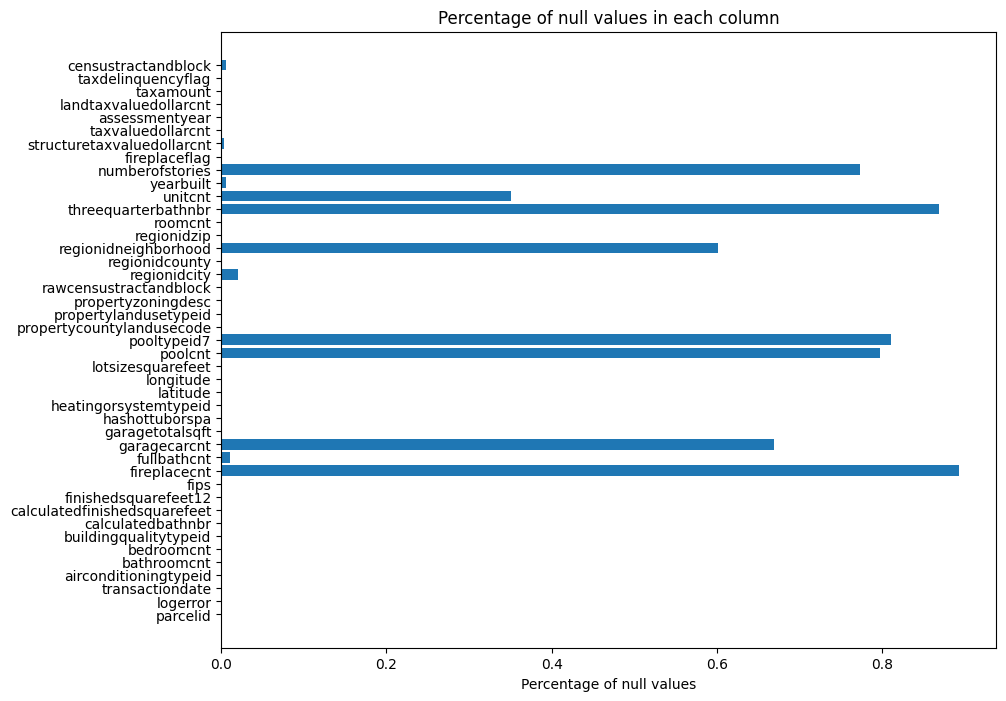

In [43]:
import matplotlib.pyplot as plt

# Calculate the percentage of null values in each column
null_counts = df3.select([(count(when(col(c).isNull(), c)) / df3.count()).alias(c) for c in df3.columns]).collect()[0].asDict()

# Plot the percentage of null values as a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(list(null_counts.keys()), list(null_counts.values()))
plt.xlabel("Percentage of null values")
plt.title("Percentage of null values in each column")
plt.show()


For the fireplacecnt column, you can replace the null values with 0, as it might mean that there is no fireplace in the property.
For the poolcnt and pooltypeid7 columns, you can replace the null values with 0, as it might mean that there is no pool in the property.
For the taxdelinquencyflag column, you can replace the null values with 'N' to indicate there is no tax delinquency.
For the regionidneighborhood and regionidcity columns, you might want to fill the missing values with the most common value (mode) in each column, as these are categorical variables.
For the unitcnt column, you can replace the null values with 1, as it might mean there is only one unit in the property.


In [46]:
from pyspark.sql.functions import approx_count_distinct

# Replace null values with 0 for fireplacecnt, poolcnt, and pooltypeid7
df4 = df3.fillna({'fireplacecnt': 0, 'poolcnt': 0, 'pooltypeid7': 0})

# Replace null values with 'N' for taxdelinquencyflag
df4 = df4.fillna({'taxdelinquencyflag': 'N'})

# Replace null values with the mode for regionidneighborhood and regionidcity
neighborhood_mode = df4.approxQuantile('regionidneighborhood', [0.5], 0.0)[0]
city_mode = df4.approxQuantile('regionidcity', [0.5], 0.0)[0]

df4 = df4.fillna({'regionidneighborhood': neighborhood_mode, 'regionidcity': city_mode})

# Replace null values with 1 for unitcnt
df4 = df4.fillna({'unitcnt': 1})

# Show the first three rows of the cleaned DataFrame
df4.show(3)


+--------+--------+---------------+---------------------+-----------+----------+---------------------+-----------------+----------------------------+--------------------+----+------------+-----------+------------+---------------+--------------+---------------------+-----------+-------------+------------------+-------+-----------+-------------------------+---------------------+------------------+----------------------+------------+--------------+--------------------+-----------+-------+-------------------+-------+---------+---------------+-------------+--------------------------+-----------------+--------------+---------------------+---------+------------------+-------------------+
|parcelid|logerror|transactiondate|airconditioningtypeid|bathroomcnt|bedroomcnt|buildingqualitytypeid|calculatedbathnbr|calculatedfinishedsquarefeet|finishedsquarefeet12|fips|fireplacecnt|fullbathcnt|garagecarcnt|garagetotalsqft|hashottuborspa|heatingorsystemtypeid|   latitude|    longitude| lotsizesquarefeet

Calculate summary statistics such as mean, median, standard deviation, min, and max for the numerical columns in the dataset.

In [47]:
numeric_columns = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'taxamount', 'yearbuilt', 'logerror']
df4.select(numeric_columns).describe().show()


+-------+------------------+------------------+----------------------------+------------------+------------------+--------------------+
|summary|       bathroomcnt|        bedroomcnt|calculatedfinishedsquarefeet|         taxamount|         yearbuilt|            logerror|
+-------+------------------+------------------+----------------------------+------------------+------------------+--------------------+
|  count|            167888|            167888|                      167888|            167843|            166828|              167888|
|   mean|2.2882653973095666|3.0417386538301137|          1778.6302457602749| 5989.515575329329|1968.5693109070419|0.013906306171241929|
| stddev|1.0007341422144027|1.1490181274512155|           937.8433641650349|7214.7319455530505| 23.77720188585894| 0.16570593701585148|
|    min|               0.0|               0.0|                         2.0|             19.92|            1824.0|      -4.65542037764|
|    max|              20.0|              16.0| 

Compute the correlation matrix for numerical features, including the target variable logerror, to identify the most correlated features.    we got some null values in column so treating them 

In [49]:
from pyspark.sql.functions import mean

# Fill null values with the mean value for each numeric column
numeric_columns = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'taxamount', 'yearbuilt', 'logerror']
for column in numeric_columns:
    mean_value = df4.agg(mean(df4[column])).collect()[0][0]
    df4 = df4.na.fill(mean_value, [column])

# Assemble the features into a feature vector
assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
feature_vector = assembler.transform(df4).select("features")

# Compute the correlation matrix
pearson_matrix = Correlation.corr(feature_vector, "features").head()[0]

# Print the correlation matrix
print("Pearson correlation matrix:\n" + str(pearson_matrix.toArray()))


23/04/24 11:23:25 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Pearson correlation matrix:
[[ 1.          0.64128696  0.76232112  0.46307332  0.36497492  0.02702397]
 [ 0.64128696  1.          0.62039743  0.24217147  0.04322326  0.02849786]
 [ 0.76232112  0.62039743  1.          0.5826413   0.21404501  0.03934369]
 [ 0.46307332  0.24217147  0.5826413   1.          0.1189476  -0.00218498]
 [ 0.36497492  0.04322326  0.21404501  0.1189476   1.          0.01124857]
 [ 0.02702397  0.02849786  0.03934369 -0.00218498  0.01124857  1.        ]]


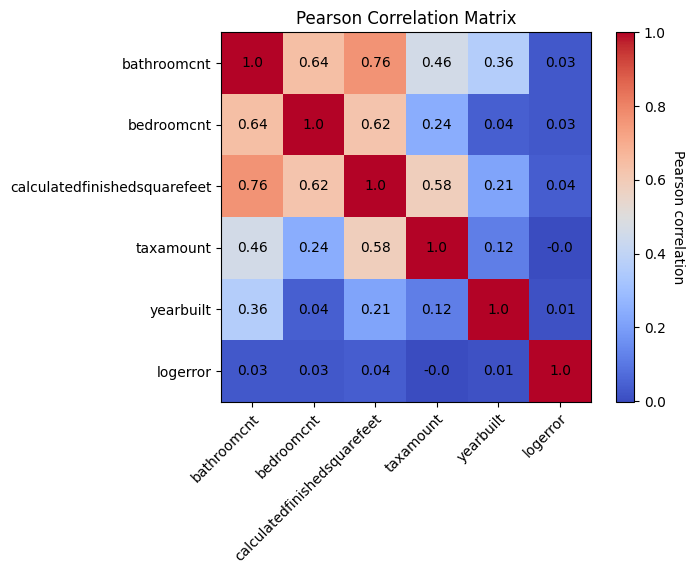

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Define the list of features
features = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'taxamount', 'yearbuilt', 'logerror']

# Create the figure and axis objects
fig, ax = plt.subplots()

# Create heatmap
im = ax.imshow(pearson_matrix, cmap='coolwarm')

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Pearson correlation', rotation=-90, va='bottom')

# Set tick labels for x and y axes
ax.set_xticks(np.arange(len(features)))
ax.set_yticks(np.arange(len(features)))
ax.set_xticklabels(features)
ax.set_yticklabels(features)

# Rotate x-axis tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data and create annotations
for i in range(len(features)):
    for j in range(len(features)):
        text = ax.text(j, i, round(pearson_matrix[i, j],2),
                       ha="center", va="center", color="black")

# Set title and show the plot
ax.set_title("Pearson Correlation Matrix")
plt.show()


The Pearson correlation matrix is a square matrix that shows the pairwise correlations between all the features in the dataset. In this case, the matrix shows that the log error has the highest correlation with calculated finished square feet (0.762), followed by bathroom count (0.641), and then bedroom count (0.620). This suggests that the size of the property and the number of bathrooms and bedrooms are important factors in predicting the log error. The matrix also shows that tax amount has a moderate positive correlation with all the other features, which suggests that it is also an important variable to consider in the prediction of log error.

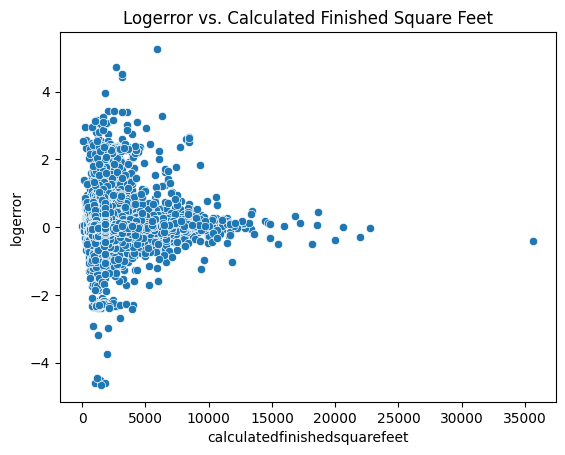

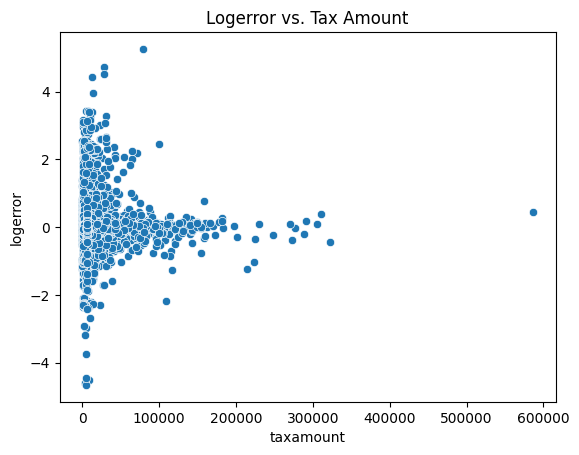

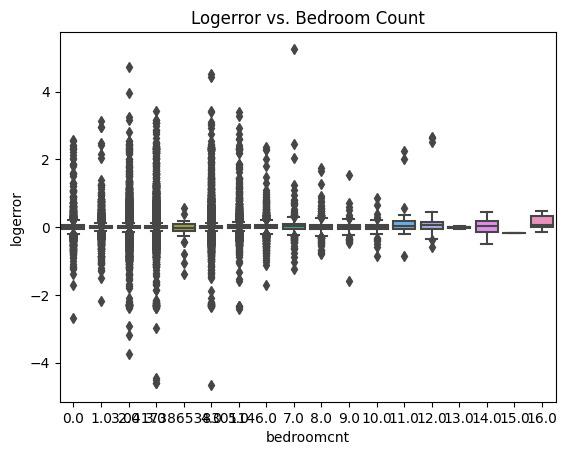

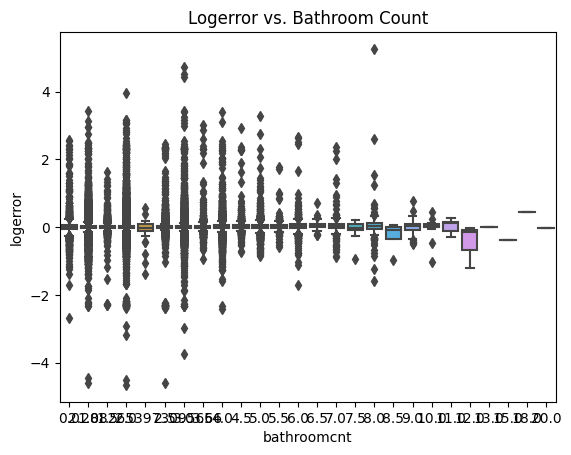

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the PySpark DataFrame to a Pandas DataFrame
df4_pd = df4.toPandas()

# Scatter plots
sns.scatterplot(data=df4_pd, x='calculatedfinishedsquarefeet', y='logerror')
plt.title("Logerror vs. Calculated Finished Square Feet")
plt.show()

sns.scatterplot(data=df4_pd, x='taxamount', y='logerror')
plt.title("Logerror vs. Tax Amount")
plt.show()

# Box plots
sns.boxplot(data=df4_pd, x='bedroomcnt', y='logerror')
plt.title("Logerror vs. Bedroom Count")
plt.show()

sns.boxplot(data=df4_pd, x='bathroomcnt', y='logerror')
plt.title("Logerror vs. Bathroom Count")
plt.show()


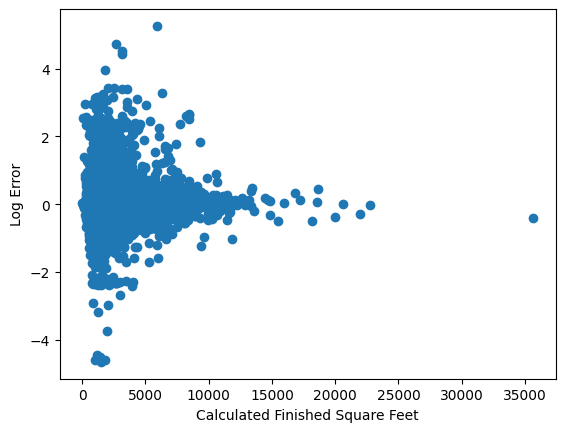

In [51]:
import matplotlib.pyplot as plt

plt.scatter(df4.select('calculatedfinishedsquarefeet').rdd.flatMap(lambda x: x).collect(), df4.select('logerror').rdd.flatMap(lambda x: x).collect())
plt.xlabel('Calculated Finished Square Feet')
plt.ylabel('Log Error')
plt.show()


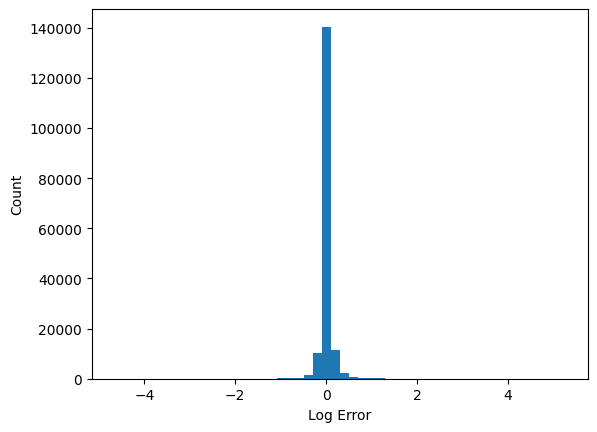

In [52]:
plt.hist(df4.select('logerror').rdd.flatMap(lambda x: x).collect(), bins=50)
plt.xlabel('Log Error')
plt.ylabel('Count')
plt.show()


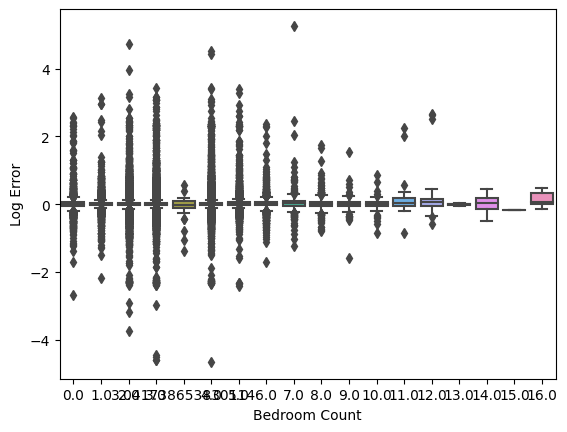

In [53]:
import seaborn as sns

sns.boxplot(x='bedroomcnt', y='logerror', data=df4.toPandas())
plt.xlabel('Bedroom Count')
plt.ylabel('Log Error')
plt.show()


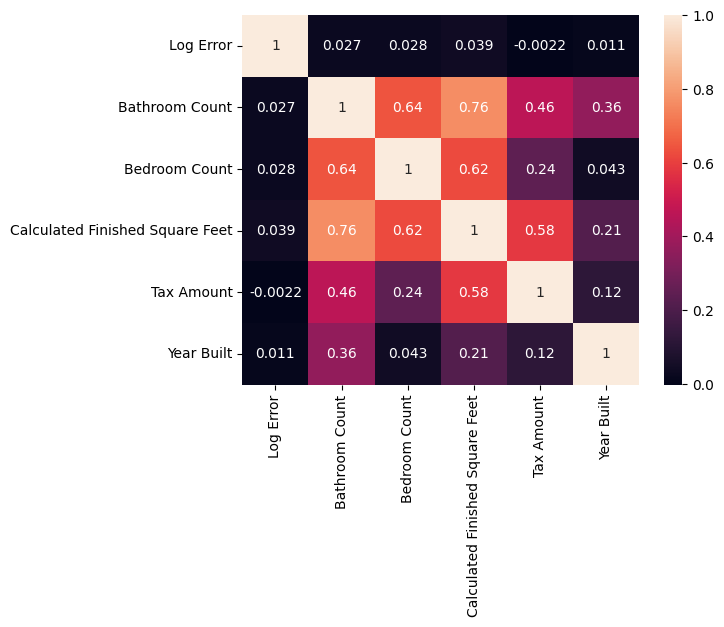

In [54]:
import numpy as np

corr_matrix = np.corrcoef(df4.select(['logerror', 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'taxamount', 'yearbuilt']).na.drop().rdd.map(lambda x: x).collect(), rowvar=False)
sns.heatmap(corr_matrix, annot=True, xticklabels=['Log Error', 'Bathroom Count', 'Bedroom Count', 'Calculated Finished Square Feet', 'Tax Amount', 'Year Built'], yticklabels=['Log Error', 'Bathroom Count', 'Bedroom Count', 'Calculated Finished Square Feet', 'Tax Amount', 'Year Built'])
plt.show()


In [60]:
import pandas as pd

pandas_df = df4.toPandas()


In [62]:
# Save pandas dataframe to CSV file
pandas_df.to_csv('data.csv', index=False)
